# Quantitive Optical Diffraction Tomography (ODT)

In this simulation, we first model the light scattering from a cylinder using Mie scattering. The full scattered field and both the Born and Rytov approximation are computed. The calculation are done based on Devaney _Mathematical foundations of imaging, tomography, and wavefield inversion_.

Then the field is computed using the Split-Step Non-Paraxial method and compared with the exact data. In the end three reconstruction techniques are shown for the reconstruction of the RI.

First we load some functions that we need for our calculations. The function `jv` is the Scipy Bessel function of the first kind $J_n(x)$. See the wiki 
page on <a href="https://en.wikipedia.org/wiki/Bessel_function">Bessel functions</a> for more details. The function `hankel1` is the Hankel function $H_{\nu}^{(1)}$ of the first kind. See the wiki page on <a href="https://en.wikipedia.org/wiki/Bessel_function#Hankel_functions:_H(1)%CE%B1,_H(2)%CE%B1">Hankel functions</a> for more details. 

In [86]:
# load modules
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import jv, hankel1
import scipy.interpolate as intp
import scipy.ndimage
# import tensorflow as tf
import param

Next we define the derivative of the Bessel function in the radial direction. The function `besselder` calculates the derivative of either the Bessel function $J_n(x)$, `Type=0`, or the derivative of the Hankel function $H_n(x)$, `Type=1`. For the Bessel and Hankel function it holds that one of the many forms of the <a href="https://functions.wolfram.com/Bessel-TypeFunctions/BesselJ/20/01/02/0001">derivative</a> is given by
$$
\begin{equation}
\frac{\partial J_n(x)}{\partial x} = J_{n-1}(x)-\frac{n}{x}J_n(x) \, .
\end{equation}
$$

Finally, note that notation wise it is $J_n$ if $n$ is an integer and $J_v$ if $v$ is a real number.

In [87]:
def besselder(l, ka, type):
    # make sure to import from scipy.special import jv and hankel1 first
    if type==0:     # Bessel
        besselder=jv(l-1,ka) - (l/ka)*jv(l,ka)
        # or equivalently
        #besselder=(l/ka)*jv(l,ka)-jv(l+1,ka)
        return besselder
    else:   # Hankel
        besselder=hankel1(l-1,ka) - (l/ka)*hankel1(l,ka)
        # or equivalently
        # besselder=(l/ka)*hankel1(l,ka)-hankel1(l+1,ka)
        return besselder

Define the constants for computing the field at the detecor using the Param package.

In [88]:
class Cylinder_Scattering(param.Parameterized):
    "Class with all the needed values for the forward and backward problem for Cylinder Scattering"

    lambda0 = param.Number(default=0.633, bounds=(0,None), doc = "The wavelength in vacuum")
    ncyl = param.Number(default= 1.01, bounds=(None,None), doc = "RI of the cylinder")
    nmed = param.Number(default= 1.0, bounds=(None,None), doc = "RI of the medium")
    nr = param.Number(default= 1.01, bounds=(None,None), constant = True, doc = "Relative RI")
    R0 = param.Number(default = 4*0.633, bounds= (0,None), doc = "Radius of the cylinder")
    k0 = param.Number(default= 2*np.pi/0.633, bounds=(0,None), constant = True, doc= "Wavenumber in vacuum")
    km = param.Number(default= 2*np.pi/0.633, bounds=(None,None), constant = True, doc= "Wavenumber in medium")
    L = param.Integer(default= 45, bounds=(0,None),  doc = "RI of the medium")
    Ltot = param.Integer(default=91, bounds=(0,None),  doc = "Total number for summation")
    z0 = param.Number(default=0.633*16, bounds=(0,None), doc = "Half the distance to the detector")
    x0 = param.Number(default=0.633*16, bounds=(0,None), doc = "Half the detector width")
    Nx = param.Integer(default = 2048, bounds=(0,None), doc = "Number of points on the detector")
    Nz = param.Integer(default = 2048, bounds=(0,None), doc = "Number of points in the z-direction")
    deltax = param.Number(default = 2*0.633*16/2048, bounds=(0,None), constant = True, doc = "detector resolution")
    deltaz = param.Number(default = 2*0.633*16/2048, bounds=(0,None), constant = True, doc = "Step size in the z-direction")
    Nphi = param.Integer(default = 64, bounds=(0,None), doc = "Number of projections")
    phi0 = param.Number(default= 0.45 * math.pi, bounds=(-math.pi/2, math.pi/2), doc = "The largest illumination angle")
    incoming_angle = param.Number(default= 0.0, bounds=(-math.pi/2, math.pi/2), doc = "The incoming angle of the plane wave")
    kx_in = param.Number(default= 0.0, constant = True, doc = "The incoming wavenumber of the plane wave (x-direction)")
    kz_in = param.Number(default= 2*np.pi/0.633, constant = True, doc = "The incoming wavenumber of the plane wave (z-direction)")
    indmax = param.Integer(default = 10, bounds=(0,None), doc = "Maximum number of iterations")
    gamma = param.Number(default= 0.2,  doc = "Weight of the L1-norm")
    learn_rate = param.Number(default= 0.1, bounds=(0,None),  doc = "The learn rate of the reconstruction")
    angle_deg = param.Integer(default = 10, bounds=(0,None), doc = "Amount of angle points")
    angle_step = param.Number(default= 360/10, constant = True, bounds=(0,None), doc = "The step for the rotation")

    def __init__(self, **params):
        super().__init__(**params)

        self._update_values()  #Sets the values of the constants accourding to the function defined below
    
    def __call__(self):
        print("lambda0 =            ", self.lambda0)
        print("ncyl =               ", self.ncyl)
        print("nmed =               ", self.nmed)
        print("nr =                 ", self.nr)
        print("R0 =                 ", self.R0)
        print("k0 =                 ", self.k0)
        print("km =                 ", self.km)
        print("L =                  ", self.L)
        print("Ltot =               ", self.Ltot)
        print("Nz =                 ", self.Nz)
        print("deltaz =             ", self.deltaz)
        print("z0 =                 ", self.z0)
        print("x0 =                 ", self.x0)
        print("Nx =                 ", self.Nx)
        print("deltax =             ", self.deltax)
        print("Nphi =               ", self.Nphi)
        print("phi0 =               ", self.phi0)
        print("incoming_angle =     ", self.incoming_angle)
        print("kx_in =              ", self.kx_in)
        print("kz_in =              ", self.kz_in)
        print("indmax =             ", self.indmax)
        print("gamma =              ", self.gamma)
        print("learn_rate =         ", self.learn_rate)
        print("angle_deg =          ", self.angle_deg)
        print("angle_step =         ", self.angle_step)        
    
    @param.depends("lambda0", "ncyl", "nmed", "R0", "z0", "x0", "Nx", "Nz", "incoming_angle", "angle_deg",  watch=True)
    def _update_values(self):
        "Updates every values"
        with param.edit_constant(self):
            self.nr = self.ncyl / self.nmed
            self.k0 = 2*math.pi / self.lambda0
            self.km = self.nmed * self.k0
            self.L = int(np.round(self.k0*self.R0)+20)
            self.Ltot = 2*self.L + 1
            self.deltax = self.x0 * 2 / self.Nx
            self.deltaz = self.z0 * 2 / self.Nz
            self.kx_in = self.km * math.sin(self.incoming_angle)
            self.kz_in = self.km * math.cos(self.incoming_angle)
            self.angle_step = 360 / self.angle_deg



In [117]:
# Make the param-class
Mie_scattering = Cylinder_Scattering(z0 = 4*0.633, x0 = 40, Nx = 1024)
Mie_scattering()

lambda0 =             0.633
ncyl =                1.01
nmed =                1.0
nr =                  1.01
R0 =                  2.532
k0 =                  9.926043139304243
km =                  9.926043139304243
L =                   45
Ltot =                91
Nz =                  2048
deltaz =              0.00247265625
z0 =                  2.532
x0 =                  40
Nx =                  1024
deltax =              0.078125
Nphi =                64
phi0 =                1.413716694115407
incoming_angle =      0.0
kx_in =               0.0
kz_in =               9.926043139304243
indmax =              10
gamma =               0.2
learn_rate =          0.1
angle_deg =           10
angle_step =          36.0


In order to compute the complex two-dimensional (2D) field $U(\mathbf{r})$ at position $\mathbf{r}$ the Mie scattering and Split-step non-paraxial (SSNP) models are used. The basis of both techniques lays in the inhomogeneous Helmholtz equation: 
\begin{equation}
    (\triangledown^2 + k_m^2) U(\mathbf{r}) = V(\mathbf{r})U(\mathbf{r}),
\end{equation}
with $k_m$ the wavenumber of the surrounding medium, $U (\mathbf{r})$ the complex field and $V(\mathbf{r})$ the scattering potential. The complex field $U(\mathbf{r})$ can then be rewritten into two parts, the incoming field $U_0(\mathbf{r})$ and the scattered field $U_s(\mathbf{r})$ such that 
\begin{equation}
    U(\mathbf{r}) = U_0 (\mathbf{r}) + U_s (\mathbf{r}).
\end{equation}

## Mie scattering
In the Mie scattering model the scattering of a homogeneous cylinder with refractive index (RI) $n_{cyl}$ in a homogeneous background RI $n_m$ can be computed exact which is discussed below based on Devaney.
When a scattering cylinder is centered at the origin, the scattering potential $V(\mathbf{r})$ can be defined as
\begin{equation}
    V(\mathbf{r}) = \left\{\begin{matrix} k_m^2\left[1-n_r^2 \right ] & r \leq R_0 ,\\  0 & r\geq R_0 , \end{matrix}\right.
\end{equation}
where $R_0$ is the radius of the cylinder, $n_r = \frac{n_{cyl}}{n_m}$ the relative refraction index and $\mathbf{r} = (r,\phi)$ the polar coordinates of the cylinder. 
For a homogeneous cylinder with relative refraction index $n_r$ which is illuminated by a incident wavefield that propagates in the $(x,z)$-plane perpendicular to the cylinder axis, the field expansion takes the form
\begin{equation}
    U(r)=\sum_{l=-\infty}^{\infty} a_l J_l(k_m n_r r) \text{e}^{i l \phi}, \, \hspace{5 mm}  \, r \leq R_0 \, ,
\end{equation}
and 
\begin{equation}
    U(r)=\sum_{l=-\infty}^{\infty} a_{0l} J_l(k_m r) \text{e}^{i l \phi} + \sum_{l=-\infty}^{\infty} b_l H_l^+(k_m r) \text{e}^{i l \phi}, \, \hspace{5 mm}  \, r \geq R_0 \, .
\end{equation}
where $J_l (x)$ is the Bessel function of the first kind, $H^+_l (x)$ the Hankel function of the first kind and $a_{0l}$, $a_l$ and $b_l$ the multipole moments. 
For all the implementation the incoming wave is defined as a plane wave which has the benefits that is has an exact multipole expansion defined as
\begin{equation}
    \text{e}^{i \vec{k}_m \cdot \vec{r}}=\text{e}^{i k_m r \cos \phi_0}=\sum_{l=-\infty}^{\infty} i^l J_l(k_m r)\text{e}^{i l\phi_0} \, ,
\end{equation}
with $\phi$ the incoming angle. Using both equations and requiring that both the solutions and radial derivatives are identical at the boundary the multipole moments $b_l$ is defined as
\begin{equation}
    b_l= R_l a_{0l} \, ,
\end{equation}
with
\begin{equation}
    R_l =  \frac{n_r J_l(k_m R_0) J_l^{'}(k_m n_r R_0) - J_l^{'}(k_m R_0) J_l(k_m n_r R_0)}{J_l(k_m n_r R_0) H_l^{+'}(k_m R_0) - n_r J_l^{'}(k_m n_r R_0) H_l^+(k_m R_0)} \, , 
\end{equation}
the reflection coefficient, which links the scattered field and the incoming field. $J_l^{'}$ and $H_l^{+'}$ are the derivatives of, respectively, the first order Bessel and Hankel functions.
Combining Eqs. \ref{eq: Theory FSP2D, scattering wave inside cylinder} - \ref{eq: Theory FSP2D, exact b_l coefficient} results in
\begin{equation}
    b_l= i^l \text{e}^{-il\phi_0}R_l,
\end{equation}
using this together with Eqs. \ref{eq: Theory the complex field} and \ref{eq: Theory FSP2D, scattering wave outside cylinder} the exact scattered field $U_s$ can be obtained
\begin{equation}
    U_s (\mathbf{r},\mathbf{s}_0) = \sum_{l=-\infty}^{\infty} i^l R_l H_l^+(k_m r) \text{e}^{i l (\phi - \phi_0)}.
\end{equation} 
The exact scattered field $U_s$ computes the field at a position $\mathbf{r}$ with multiple scattering included, however in the upcoming sections the Born approximation is needed since this reduces the multiple scattering problem to a single scattering problem. The Born approximation is defined as 
\begin{equation}
    U^{(B)} (\mathbf{r}) = U_0 (\mathbf{r}) + \iint d^2 r' G_{0_+} (\mathbf{r} - \mathbf{r}') V(\mathbf{r}')U_0 (\mathbf{r})
\end{equation}
with $G_{0_+} (\mathbf{r} - \mathbf{r}')$ the Green function. Because the Born approximation is only computed from the incoming field and not the scattered field the mathematical difficulty is reduced. The Green function is defined as
\begin{equation}
    (\triangledown^2+k_m^2)G_{0_+}(\mathbf{r}-\mathbf{r}') = \delta(\mathbf{r}-\mathbf{r}'),
\end{equation}
with $\delta(\mathbf{r}-\mathbf{r}')$ the delta peak. For the 2D-case $G_{0_+} (\mathbf{r} - \mathbf{r}')$ is proportional to the zero-order Hankel function of the first kind
\begin{equation}
    G_{0_+}(\mathbf{r}-\mathbf{r}') = - \frac{i}{4} H_0^{(1)}(k_m|\mathbf{r}-\mathbf{r}'|). 
\end{equation}
This is the starting point for the derivation of the single scattered field $U_s^{(B)}$. This scattered field can again be computed using the multipole expansion
\begin{equation}
    U^{B}_{s}(\mathbf{r}) = -\frac{i}{4} \sum_{l=-\infty}^{\infty} q_l H_l^{+}(k_0 \mathbf{r}) \text{e}^{i l \phi} \, ,
\end{equation}
with the multipole moments $q_l$ given by 
\begin{equation}
    q_l = \iint_{\tau_0} dr^2 V(r) U_0 (r) J_l(k_0 r) \text{e}^{- i l \phi}= \int_0^{R_0} \int_0^{2\pi} r dr d\phi V(r) U_0 (r) J_l(k_0 r) \text{e}^{- i l \phi} .
\end{equation}
By implementing the incoming field defined in Eq. \ref{eq: Theory FSP2D, incoming wave} the equation reduces to
\begin{equation}
    q_l= 2 \pi \int_0^{R_0} r \text{d}r V(r) J_l^2(k_0 r) a_{0l}\, .
\end{equation}
The coefficients before the Hankel function in Eq. \ref{eq: Born approximation with q} can be grouped and written as a reflection coefficient multiplied with the coefficient of the incoming field, which is the same approach as with the exact field, such that
\begin{equation}
    U_B(r)=  \sum_{l=-\infty}^{\infty} R_l^{(B)} a_{0l} H_l^{+}(k_0 r) \text{e}^{i l \phi} \, ,
\end{equation}
with 
\begin{equation}
    R_l^{(B)}= -i\frac{\pi}{2} \int_0^{R_0} r \text{d}r J_l^2(k_0 r) V(r) = =-i\frac{\pi}{2} K_0^2(1- n_r^2) \mu_l^2(k_0 R_0) \, .
\end{equation}
and 
\begin{equation}
    \mu_l^2(k_0 R_0) = \int_0^{R_0} r \text{d}r J_l^2(k_0 r) =\frac{R_0^2}{2}[J_l^2(k_0 R_0) - J_{l-1}(k_0 R_0)J_{l+1}(k_0 R_0)].
\end{equation}
Since the Born approximation only deals with the single scattered field, this approximation is only valid when $U_s \ll U_0$. \\ 
Next to the Born approximation, the Rytov approximation can be used, which is defined as 
\begin{equation}
    U=\text{e}^{\phi_0 + \phi_1 +\phi_2 +...} \, ,
\end{equation}
by defining $U_0 = \text{e}^{\phi_0}$ then the first Rytov approximation will be defined as 
\begin{equation}
    U_s^{(R)} =  \text{e}^{\phi_1},
\end{equation}
which can be also be written as a function of the Born approximation
\begin{equation}
        U^{(R)}_s=U_i \text{e}^{\frac{U^{(B)}_s}{U_i}} \, ,
\end{equation}
which is just like the Born approximation only valid for weak scatters. The Rytov approximation is generally speaking more accurate than the Born approximation and has a greater domain of applicability.

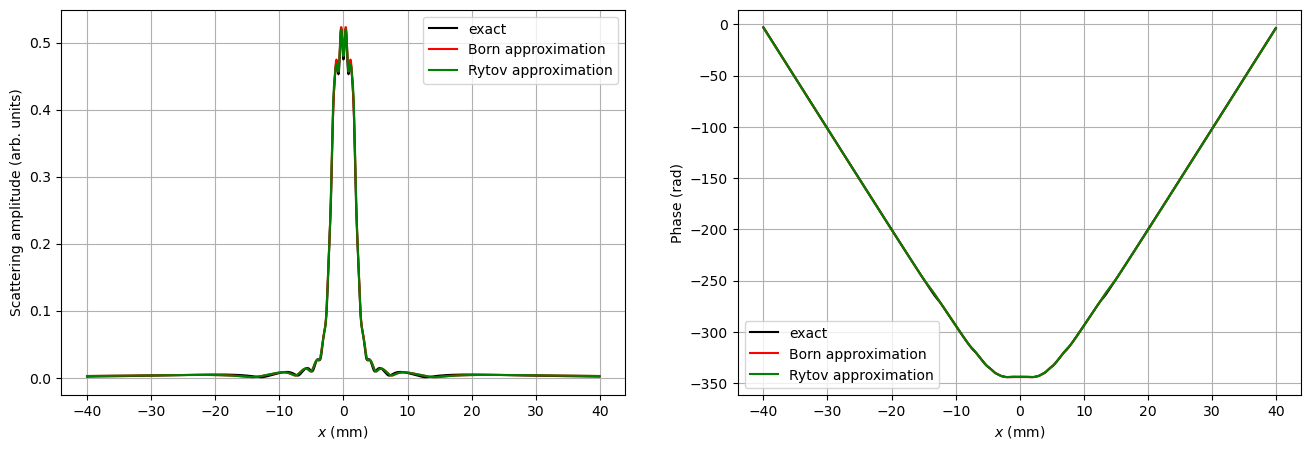

In [118]:
# Implementation of the Born, Rytov and exact field
def Compute_Wave_Mie(param):
    # define refractive index contrast
    nr=param.ncyl/param.nmed

    # pre-allocate some arrays
    denom=np.zeros([param.Ltot,1], dtype=complex)
    numer=np.zeros([param.Ltot,1], dtype=complex)
    mu2=np.zeros([param.Ltot,1], dtype=complex)
    # Define l-array
    l=np.linspace(param.L-param.Ltot+1, param.Ltot-param.L-1, param.Ltot, dtype=int)


    for ll in l: 
        # compute transmission coefficient from chap 8
        denom[ll]=jv(ll,param.k0*nr*param.R0)*besselder(ll,param.k0*param.R0,1) - nr*besselder(ll,param.k0*nr*param.R0,0)*hankel1(ll,param.k0*param.R0)
        numer[ll]=nr*jv(ll,param.k0*param.R0)*besselder(ll,param.k0*nr*param.R0,0) - besselder(ll,param.k0*param.R0,0)*jv(ll,param.k0*nr*param.R0)
        mu2[ll]= param.R0**2/2*((jv(ll,param.k0*param.R0))**2-jv(ll-1,param.k0*param.R0)*jv(ll+1,param.k0*param.R0))


    # compute transmission function
    eps = np.finfo(float).eps

    # calculate transmission coefficient according to Eq. 6.17b
    R=numer/(denom+eps)
    RB=-1j*np.pi/2*param.k0**2*(1-param.nr**2)*mu2

    x=np.linspace(-param.x0, param.x0-param.deltax, param.Nx)

    phi=np.arctan(x/param.z0)
    r=np.sqrt(x**2+param.z0**2)

    # R_exact is calculated above
    Uexact=np.zeros([param.Nx], dtype=complex)
    UB=np.zeros([param.Nx], dtype=complex)

    for i in range(param.Nx):
        for ll in l:
            # exact calculation
            bl=1j**ll*R[ll]
            Uexact[i] += hankel1(ll, param.k0*r[i])*bl*np.exp(1j*ll*(phi[i]-param.incoming_angle))
            blB=1j**ll*RB[ll]
            UB[i]=UB[i]+hankel1(ll, param.k0*r[i])*blB*np.exp(1j*ll*(phi[i]-param.incoming_angle))

    UR=np.exp(1j*param.k0*param.z0)*(np.exp(UB/np.exp(-1j*param.k0*param.z0))-1)

    return Uexact, UB, UR

# Run the function
Uexact, UB, UR = Compute_Wave_Mie(Mie_scattering)

# Plot the values
x_array = np.linspace(-Mie_scattering.x0, Mie_scattering.x0-Mie_scattering.deltax, Mie_scattering.Nx)

plt.figure(1, figsize=[16,5])
plt.subplot(121)
plt.plot(x_array, np.abs(Uexact),'k-', label='exact')
plt.plot(x_array, np.abs(UB),'r-', label='Born approximation')
plt.plot(x_array, np.abs(UR),'g-', label='Rytov approximation')
plt.ylabel('Scattering amplitude (arb. units)')
plt.xlabel('$x$ (mm)')
plt.grid(), plt.legend()

plt.subplot(122)
plt.plot(x_array, np.unwrap(np.angle(Uexact)),'k-', label='exact')
plt.plot(x_array, np.unwrap(np.angle(UB)),'r-', label='Born approximation')
plt.plot(x_array, np.unwrap(np.angle(UR)),'g-', label='Rytov approximation')
plt.ylabel('Phase (rad)')
plt.xlabel('$x$ (mm)')
plt.grid(), plt.legend()
plt.show()

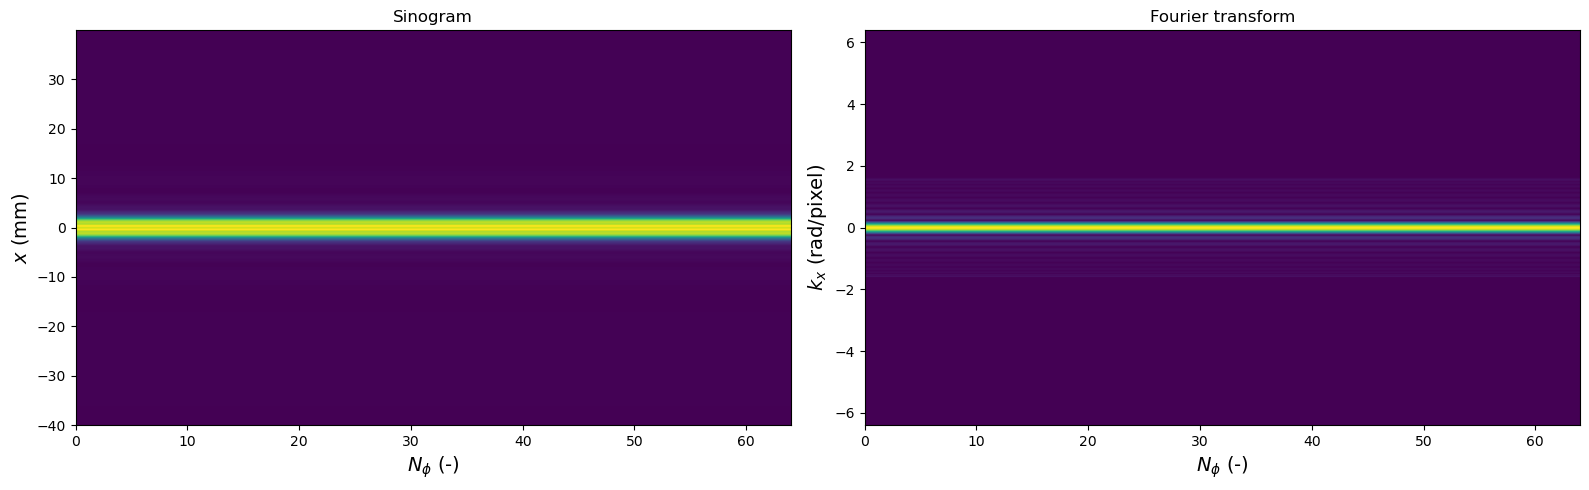

In [119]:
# setting up the tomography data
U1 = np.expand_dims(UB, axis=1)
# repeat the data in the column direction
sinogram=np.repeat(U1, Mie_scattering.Nphi, axis=1)

# Plot sinogram together with the Fourier transform
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.title('Sinogram')
plt.imshow(np.abs(sinogram), aspect = 'auto', extent = [0, Mie_scattering.Nphi,np.min(x_array),np.max(x_array)])
plt.ylabel('$x$ (mm)',fontsize = 14)
plt.xlabel('$N_{\phi}$ (-)',fontsize = 14)

# calculate the FT in the projection direction
sinogramFT = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=0), axis=0), axes=0)
kx = np.fft.fftfreq(Mie_scattering.Nx, Mie_scattering.deltax)

plt.subplot(122)
plt.title('Fourier transform')
plt.imshow(np.abs(sinogramFT), aspect = 'auto', extent = [0, Mie_scattering.Nphi,np.min(kx),np.max(kx)])
plt.ylabel('$k_x$ (rad/pixel)',fontsize = 14)
plt.xlabel('$N_{\phi}$ (-)',fontsize = 14)
plt.tight_layout()
plt.show()

For the limited angle case (introduced later in this paper), the sinogram is needed with different input angles. This is implemented below. Two versions of this equations are introduced such that the exact and Born can be used with shorter computation time.

In [120]:
def limited_angle_compute_sinogram_born(param):
    
    l=np.linspace(param.L-param.Ltot+1, param.Ltot-param.L-1, param.Ltot, dtype=int)

    # pre-allocate some arrays
    mu2=np.zeros([param.Ltot,1], dtype=complex)
    for ll in l: 
        # compute transmission coefficient from chap 8
        mu2[ll]= param.R0**2/2*((jv(ll,param.k0*param.R0))**2-jv(ll-1,param.k0*param.R0)*jv(ll+1,param.k0*param.R0))



    # # calculate reflection coefficient according to Eq. 6.17b
    x=np.linspace(-param.x0, param.x0-param.deltax, param.Nx)

    phi=np.arctan(x/param.z0)

    r=np.sqrt(x**2+param.z0**2)

    RB=-1j*np.pi/2*param.k0**2*(1-param.nr**2)*mu2

    l=np.linspace(param.L-param.Ltot+1, param.Ltot-param.L-1, param.Ltot, dtype=int)

    sinogram = np.empty([param.Nx, param.Nphi], dtype = complex)
    phi0 = np.linspace(-param.phi0,param.phi0, param.Nphi)
    for j in range(param.Nphi):
        UB=np.zeros([param.Nx], dtype=complex)
        for i in range(param.Nx):
            for ll in l:
                blB=1j**ll*RB[ll]
                UB[i]=UB[i]+hankel1(ll, param.k0*r[i])*blB*np.exp(1j*ll*(phi[i]-phi0[j]))

        sinogram[:,j] = UB
        
    return sinogram

def limited_angle_compute_sinogram_exact(param):
    
    l=np.linspace(param.L-param.Ltot+1, param.Ltot-param.L-1, param.Ltot, dtype=int)

    # pre-allocate some arrays
    denom=np.zeros([param.Ltot,1], dtype=complex)
    numer=np.zeros([param.Ltot,1], dtype=complex)
    
    for ll in l: 
        # compute transmission coefficient from chap 8
        denom[ll]=jv(ll,param.k0*param.nr*param.R0)*besselder(ll,param.k0*param.R0,1) - param.nr*besselder(ll,param.k0*param.nr*param.R0,0)*hankel1(ll,param.k0*param.R0)
        numer[ll]=param.nr*jv(ll,param.k0*param.R0)*besselder(ll,param.k0*param.nr*param.R0,0) - besselder(ll,param.k0*param.R0,0)*jv(ll,param.k0*param.nr*param.R0)
       

    # compute transmission function
    eps = np.finfo(float).eps

    # # calculate reflection coefficient according to Eq. 6.17b
    R=numer/(denom+eps)

    x=np.linspace(-param.x0, param.x0-param.deltax, param.Nx)

    phi=np.arctan(x/param.z0)

    r=np.sqrt(x**2+param.z0**2)

    l=np.linspace(param.L-param.Ltot+1, param.Ltot-param.L-1, param.Ltot, dtype=int)



    sinogram = np.empty([param.Nx, param.Nphi], dtype = complex)
    phi0 = np.linspace(-param.phi0,param.phi0, param.Nphi)
    for j in range(param.Nphi):
        U=np.zeros([param.Nx], dtype=complex)
        for i in range(param.Nx):
            for ll in l:
                # exact calculation
                bl=1j**ll*R[ll]
                U[i]=U[i]+hankel1(ll, param.k0*r[i])*bl*np.exp(1j*ll*(phi[i]-phi0[j]))   # 6.28
                
        sinogram[:,j] = U
        
    return sinogram

In [121]:
# Compute sinograms with exact and born field
sinogram_LA_born = limited_angle_compute_sinogram_born(Mie_scattering)
sinogram_LA_exact = limited_angle_compute_sinogram_exact(Mie_scattering)

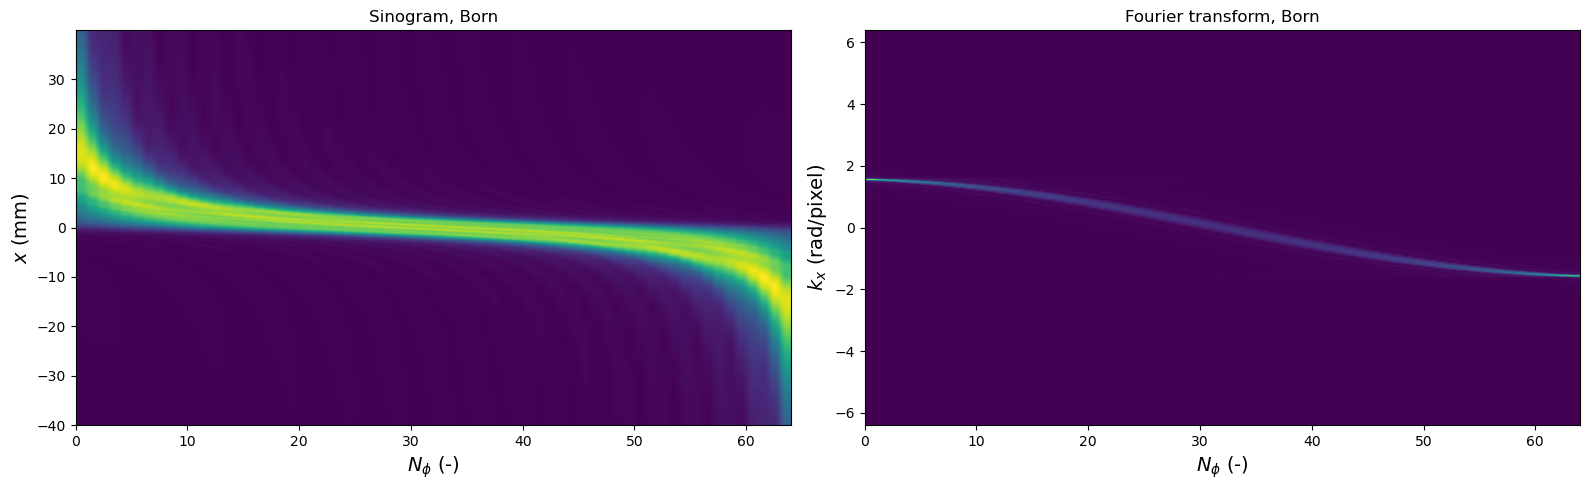

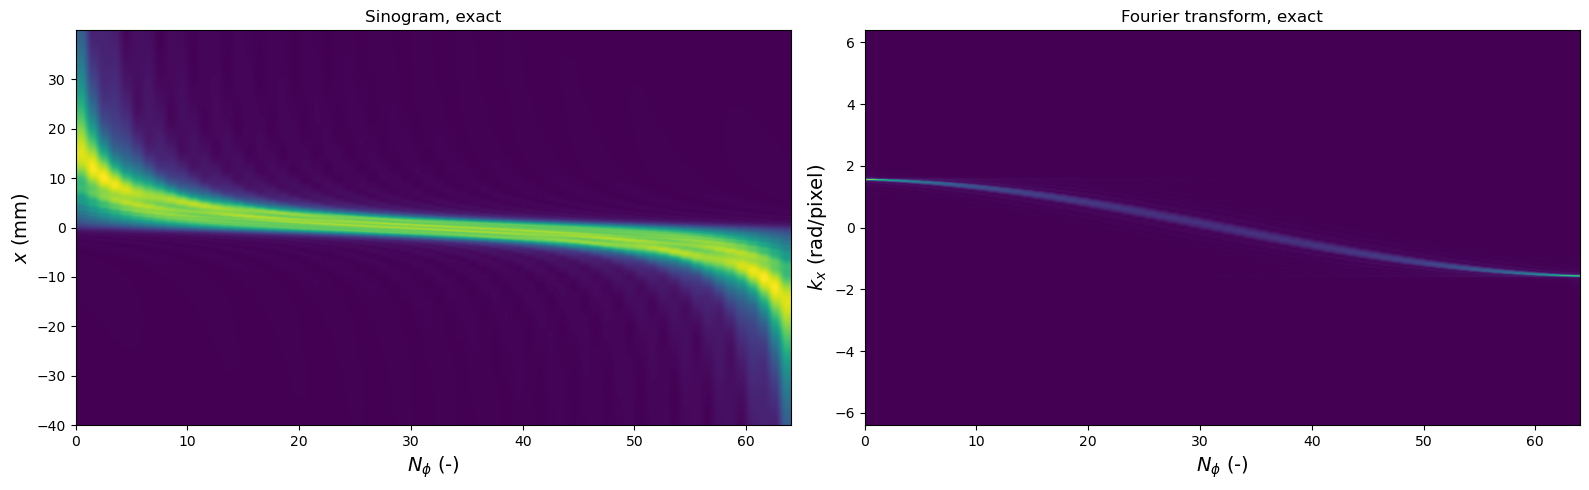

In [122]:
# Plot sinogram together with the Fourier transform
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.title('Sinogram, Born')
plt.imshow(np.abs(sinogram_LA_born), aspect = 'auto', extent = [0, Mie_scattering.Nphi,np.min(x_array),np.max(x_array)])
plt.ylabel('$x$ (mm)',fontsize = 14)
plt.xlabel('$N_{\phi}$ (-)',fontsize = 14)

# calculate the FT in the projection direction
sinogram_LA_bornFT = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(sinogram_LA_born, axes=0), axis=0), axes=0)
kx = np.fft.fftfreq(Mie_scattering.Nx, Mie_scattering.deltax)

plt.subplot(122)
plt.title('Fourier transform, Born')
plt.imshow(np.abs(sinogram_LA_bornFT), aspect = 'auto', extent = [0, Mie_scattering.Nphi,np.min(kx),np.max(kx)])
plt.ylabel('$k_x$ (rad/pixel)',fontsize = 14)
plt.xlabel('$N_{\phi}$ (-)',fontsize = 14)
plt.tight_layout()
plt.show()

# Plot sinogram together with the Fourier transform
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.title('Sinogram, exact')
plt.imshow(np.abs(sinogram_LA_exact), aspect = 'auto', extent = [0, Mie_scattering.Nphi,np.min(x_array),np.max(x_array)])
plt.ylabel('$x$ (mm)',fontsize = 14)
plt.xlabel('$N_{\phi}$ (-)',fontsize = 14)

# calculate the FT in the projection direction
sinogram_LA_exactFT = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(sinogram_LA_exact, axes=0), axis=0), axes=0)
kx = np.fft.fftfreq(Mie_scattering.Nx, Mie_scattering.deltax)

plt.subplot(122)
plt.title('Fourier transform, exact')
plt.imshow(np.abs(sinogram_LA_exactFT), aspect = 'auto', extent = [0, Mie_scattering.Nphi,np.min(kx),np.max(kx)])
plt.ylabel('$k_x$ (rad/pixel)',fontsize = 14)
plt.xlabel('$N_{\phi}$ (-)',fontsize = 14)
plt.tight_layout()
plt.show()

The Fourier diffraction theorem relates the diffraction pattern observed in the far-field region, for example at a detector, to the spatial distribution of the object in the near-field region. The derivation is based on Mueller \cite{müller2016theory}. Instead of computing the refractive index $n(\mathbf{r})$ directly, first the scattering potential is computed which is generally defined as

\begin{equation}
    V(\mathbf{r}) = k_m^2 \left (1-\left (\frac{n(\mathbf{r})}{n_m} \right)^2 \right),
\end{equation}

with $n_m$ the refractive index of the surrounded medium. In the 2D case, the Green's functions is proportional to the zero-order Hankel function of the first kind as defined earlier. This can be used together with the definition of this Hankel function to define the Green function \cite{GreenHankel}
\begin{equation}
    H_0 (k_m|\mathbf{r}-\mathbf{r}'|) = \frac{1}{\pi} \int dk_x\frac{\text{e}^{i[k_x(x-x')+\sqrt{k_m^2-k_x^2}(z-z')]}}{\sqrt{k_m^2-k_x^2}},
\end{equation}

\begin{equation}
    G_{0_+}(\mathbf{r}-\mathbf{r}') = - \frac{i}{4 \pi} \int dk_x\frac{\text{e}^{i[k_x(x-x')+\sqrt{k_m^2-k_x^2}(z-z')]}}{\sqrt{k_m^2-k_x^2}}.
\end{equation}
We define our incoming plane wave $U_0 (\mathbf{r})$ with amplitude $a_0$, propagation direction $\mathbf{s}_0$ and wavenumber $k_m$ as
\begin{equation}
    U_0(\mathbf{r}) = a_0 \text{e}^{ik_m \mathbf{s}_0 \cdot \mathbf{r}}.
\end{equation}
Using this as our definition, the first Born approximation in two dimensions reads
\begin{equation}
    U_s^{(B)} (\mathbf{r}) = \iint d^2 r' G_{0_+}(\mathbf{r}-\mathbf{r}') V(\mathbf{r}') U_0(\mathbf{r}') = \iint d^2 r' G_{0_+}(\mathbf{r}-\mathbf{r}') V(\mathbf{r}')  a_0 \text{e}^{ik_m \mathbf{s}_0 \cdot \mathbf{r}}.
\end{equation}

\begin{equation}
    U_s^{(B)} (\mathbf{r}) = - \frac{i}{4 \pi} \iint  d^2 r'\int dk_x\frac{\text{e}^{i[k_x(x-x')+\sqrt{k_m^2-k_x^2}(z-z')]}}{\sqrt{k_m^2-k_x^2}} V(\mathbf{r}') a_0 \text{e}^{ik_m \mathbf{s}_0 \cdot \mathbf{r}}.
\end{equation}
By introducing the Fourier transform of $V(\mathbf{r}')$ as $\mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0)) $ written as the integral over $\mathbf{r}'$ as follows
\begin{equation}
    \mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0)) =   \iint  d^2 r' V(r') \text{e}^{-ik_m (\mathbf{s}-\mathbf{s}_0)\cdot \mathbf{r'}},
\end{equation}
and implementing this in the Born approximation such that
\begin{equation}
    U_s^{(B)} (\mathbf{r}) = - \frac{i a_0 }{4\pi} \int dk_x \frac{ \mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0))  \text{e}^{ik_m \mathbf{s} \cdot \mathbf{r}}}{\sqrt{k_m^2-k_x^2}}.
\end{equation}
This equation is true for every angle $\phi$ where the detector is placed and $\mathbf{r} = (x_D, l_0)$, with $x_D$ the position on the detector and $l_0$ the distance from the center of the cylinder to the detector. In order to arrive at the Fourier Diffraction Theorem, one will perform a one-dimensional Fourier transform of $U_B (\mathbf{r})$ along $x_D$ such that
\begin{equation}
    \mathcal{F}_{x_D} (U_s^{(B)}) (k_{Dx}, \phi) =  - \frac{i a_0 }{4\pi} \int dx_D \int dk_x \frac{ \mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0)) }{\sqrt{k_m^2-k_x^2}} \text{e}^{ik_x x_D + i \sqrt{k_m^2 - k_x^2}l_0} \text{e}^{-ik_{Dx}x_{Dx}}.
\end{equation}
By identifying the delta distribution as
\begin{equation} 
    \delta(k_x - k_{Dx}) = \frac{1}{2\pi} \int dx_D \text{e}^{i (k_x - k_{Dx})x_D},
\end{equation}

\begin{equation}
   \mathcal{F}_{x_D} (U_s^{(B)}) (k_{Dx}, \phi) = -\frac{i a_0 }{2} \frac{ \mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0)) }{\sqrt{k_m^2-k_{Dx}^2}} \text{e}^{ i \sqrt{k_m^2 - k_{Dx}^2}l_0} .
\end{equation}
Via this equation one can find the Fourier Transform of the scattering potential as follows
\begin{equation}
     \mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0))  = - \frac{2}{i a_0} \sqrt{k_m^2-k_{Dx}^2} \mathcal{F}_{x_D} (U_s^{(B)}) (k_{Dx}, \phi) \text{e}^{- i \sqrt{k_m^2 - k_{Dx}^2}l_0} .
\end{equation}
In order to eliminate $a_0$ in this equation, one uses the following trick

\begin{equation}
    \frac{\mathcal{F}_x \left \{U_s^{(B)} (x) \right \}}{a_0} = \frac{\mathcal{F}_x \left \{U_s^{(B)} (x) \right \}}{a_0}  = \mathcal{F}_x \left \{\frac{U_s^{(B)} (x)}{U_0(l_0)}\text{e}^{ik_m l_0} \right \}= \frac{\mathcal{F}_x \left \{ U_s^{(B)} \right \} \text{e}^{ik_m l_0}}{U_0 (l_0)}.
\end{equation}

Using this substitution gives us the Fourier Diffraction Theorem
\begin{equation}
         \mathcal{F}_x(V)(k_m(\mathbf{s}-\mathbf{s}_0))  = - \frac{2}{i} \sqrt{k_m^2-k_{Dx}^2}  \text{e}^{- i \left(\sqrt{k_m^2 - k_{Dx}^2} - k_m \right)l_0} \mathcal{F}_{x_D} (U_s^{(B)}) (k_{Dx}, \phi) .
\end{equation}
The Fourier transform of the scattered wave $\mathcal{F}_{x_D} (U_s^{(B)}) (k_{Dx})$ needs to be placed on circular arcs in Fourier space such that
\begin{equation}
    k_m (\mathbf{s}  -\mathbf{s}_0) = \left( k_{Dx} \cos{\phi} - \sqrt{k_m^2 - k_{Dx}^2}\sin{\phi} , k_{Dx} \sin{\phi}+ \sqrt{k_m^2 - k_{Dx}^2} \cos{\phi} \right).
\end{equation} 
This is called the OR case.
The reconstruction of the Limited Angle (LA) case is comparable to the OR case. However, there is a change in the position of the circular arcs in the Fourier space such that 
\begin{equation}
    k_m (\mathbf{s} -\mathbf{s}_0) = \left( k_{Dx} - k_m \sin{\phi} ,  \sqrt{k_m^2 - k_{Dx}^2} + k_m(1-\cos{\phi}) \right),
\end{equation}


In [123]:
# The OR case
def Fourier_Backprojection_Theorem_OR(sinogram, param, plot_sampling = False):
    x=np.linspace(-param.x0, param.x0-param.deltax, param.Nx)

    UBFT = np.fft.fft(np.fft.fftshift(sinogram, axes=0), axis=0)
    kx = 2 * np.pi * np.fft.fftfreq(len(sinogram), param.deltax)
    filter_klp_plot = (kx**2 < param.km**2)

    kx = kx.reshape(-1, 1)

    filter_klp = (kx**2 < param.km**2)


    # Compute kxl and kzl (in rotated system ϕ₀)
    kxl = kx
    kzl = np.sqrt(filter_klp*(param.km**2 - kx**2)) - param.km

    Fsin = (2/1j)*np.sqrt(filter_klp*(param.km**2 - kx**2)) * np.exp(-1j *kzl * param.z0)

    UBfiltered =  Fsin*UBFT

    theta = np.linspace(0, 2*np.pi, param.Nphi)
    theta = theta.reshape(1,-1)


    # the shape of the angular array is the same as that of the sinogram
    # one column per angle
    krx = np.cos(theta) * kxl + np.sin(theta) * kzl
    krz = - np.sin(theta) * kxl + np.cos(theta) * kzl

    Kx, Kz = np.meshgrid(kx, kx)

    Xf= krx.flatten()
    Zf= krz.flatten()
    Dataf= UBfiltered.flatten()

    Fcomp = intp.griddata((Xf, Zf), Dataf, (Kx, Kz))

    # remove nans
    Fcomp[np.where(np.isnan(Fcomp))] = 0

    # Filter data, only allow for propagating waves
    Fcomp[np.where(np.sqrt(Kx**2 + Kz**2) > np.sqrt(2) * param.km)] = 0

    # Fcomp is centered at K = 0 due to the way we chose kintp/coords
    objectFD = (1/param.deltax)*np.fft.fftshift(np.fft.ifft2(Fcomp))[::-1]

   
    if plot_sampling:
        plt.figure(figsize=[10,5])
        plt.subplot(121)
        theta_for_plot = np.linspace(0,2*np.pi, 64)
        kmx=param.km*np.cos(theta_for_plot)
        kmy=param.km*np.sin(theta_for_plot)
        plt.plot(kmx, kmy, '--r')        

        for i in range(0, param.Nphi, 4):
            plt.plot(krx[filter_klp_plot,i], krz[filter_klp_plot,i], 'o', markersize=3)

        plt.grid(), plt.title('Fourier domain sampling')
        plt.xlim([-1.5*np.min(param.km), 1.5*np.max(param.km)]), plt.ylim([-1.5*np.min(param.km), 1.5*np.max(param.km)])
        plt.xlabel('$k_x$ (rad/pixel)'), plt.ylabel('$k_z$ (rad/pixel)')
        plt.subplot(122)
        plt.title('Cartesian frequency grid')
        plt.plot(Kx, Kz, 'ok', markersize=3)
        plt.xlim([1.5*np.min(kx), 1.5*np.max(kx)]), plt.ylim([1.5*np.min(kx), 1.5*np.max(kx)]), plt.grid()
        plt.xlabel('$k_x$ (rad/pixel)'), plt.ylabel('$k_z$ (rad/pixel)')
        plt.tight_layout()

        plt.show()
        
    
    RI = param.nmed * np.sqrt(objectFD / param.km**2 + 1)

    return RI

# The LA case:
# Limited angle implementation
def Fourier_Backprojection_Theorem_LA(sinogram, param, plot_sampling = False):
    x=np.linspace(-param.x0, param.x0-param.deltax, param.Nx)

    UBFT = np.fft.fft(np.fft.fftshift(sinogram, axes=0), axis=0)
    kx = 2 * np.pi * np.fft.fftfreq(len(sinogram), param.deltax)
    filter_klp_plot = (kx**2 < param.km**2)

    kx = kx.reshape(-1, 1)

    filter_klp = (kx**2 < param.km**2)


    # Compute kxl and kzl (in rotated system ϕ₀)
    kxl = kx
    kzl = np.sqrt(filter_klp*(param.km**2 - kx**2)) - param.km 

    Fsin = (2/1j)*np.sqrt(filter_klp*(param.km**2 - kx**2)) * np.exp(-1j*kzl*param.z0)

    UBfiltered =  Fsin*UBFT 

    theta = np.linspace(-param.phi0, param.phi0, param.Nphi)
    theta = theta.reshape(1,-1)
    krx = kxl -  param.km*np.sin(theta) 
    krz = kzl + param.km*(1 - np.cos(theta)) 
    dkx = kx[1]-kx[0]
    kx_mesh = np.arange(np.min(krx), -1*np.min(krx)+dkx, dkx)

    kx_mesh = np.fft.ifftshift(kx_mesh)

    Kx, Kz = np.meshgrid(kx_mesh, kx)

    Xf= krx.flatten()
    Zf= krz.flatten()
    Dataf= UBfiltered.flatten()

    Fcomp = intp.griddata((Xf, Zf), Dataf, (Kx, Kz))

    # remove nans
    Fcomp[np.where(np.isnan(Fcomp))] = 0

    # Filter data, only allow for propagating waves
    Fcomp[np.where(np.sqrt(Kx**2 + Kz**2) > np.sqrt(2) * param.km)] = 0

    # Fcomp is centered at K = 0 due to the way we chose kintp/coords
    objectFD = (1/param.deltax)*np.fft.fftshift(np.fft.ifft2(Fcomp))[::-1] 

   
    if plot_sampling:
        theta_for_plot = np.linspace(0,2*np.pi, 64)
        kmx=param.km*np.cos(theta_for_plot)
        kmy=param.km*np.sin(theta_for_plot)

        
        plt.figure(figsize=[10,5])
        plt.subplot(121)
        plt.plot(kmx, kmy, '--r')
        plt.plot(2*kmx, 2*kmy, '--k')

        for i in range(0, param.Nphi, 4):
            plt.plot(krx[filter_klp_plot,i], krz[filter_klp_plot,i], 'o', markersize=3)
            

        plt.grid(), plt.title('Fourier domain sampling')
        plt.xlim([-2.5*np.min(param.km), 2.5*np.max(param.km)]), plt.ylim([-2.5*np.min(param.km), 2.5*np.max(param.km)])
        plt.xlabel('$k_x$ (rad/pixel)'), plt.ylabel('$k_z$ (rad/pixel)')
        
        plt.subplot(122)
        plt.title('Cartesian frequency grid')
        plt.plot(Kx, Kz, 'ok', markersize=3)
        plt.xlabel('$k_x$ (rad/pixel)'), plt.ylabel('$k_z$ (rad/pixel)')
        plt.xlim([1.5*np.min(kx), 1.5*np.max(kx)]), plt.ylim([1.5*np.min(kx), 1.5*np.max(kx)])
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    RI = param.nmed * np.sqrt(objectFD / param.km**2 + 1)
    
    return RI

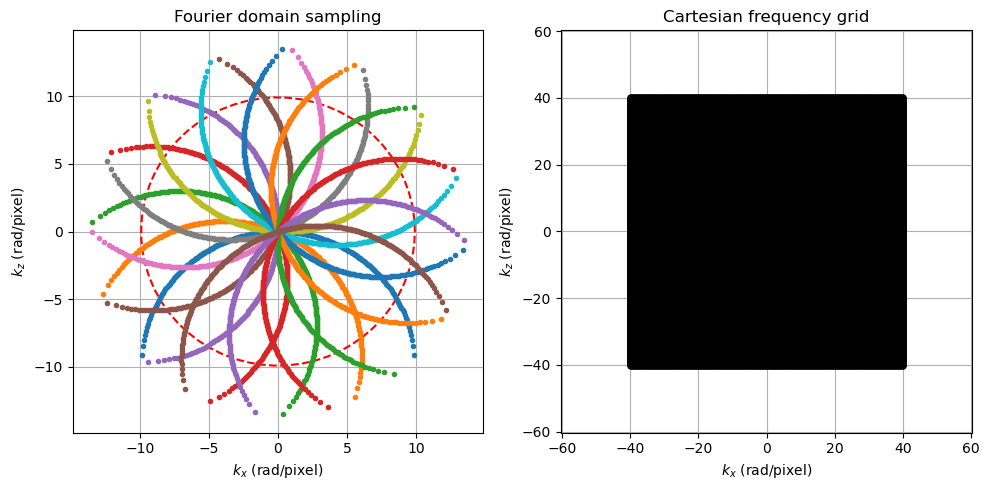

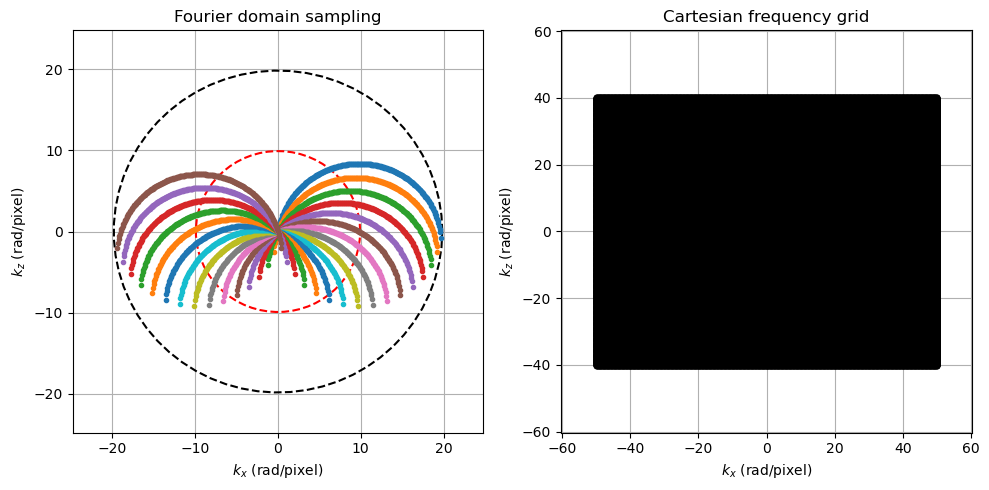

In [124]:
RI_OR = Fourier_Backprojection_Theorem_OR(sinogram, Mie_scattering, plot_sampling=True)
RI_LA = Fourier_Backprojection_Theorem_LA(sinogram_LA_born, Mie_scattering, plot_sampling=True)

In [125]:
# Compute true object for comparision
object = (x_array[None,:]**2 + x_array[:,None]**2) < Mie_scattering.R0**2
RI_true = Mie_scattering.nmed + (Mie_scattering.ncyl - Mie_scattering.nmed) * object

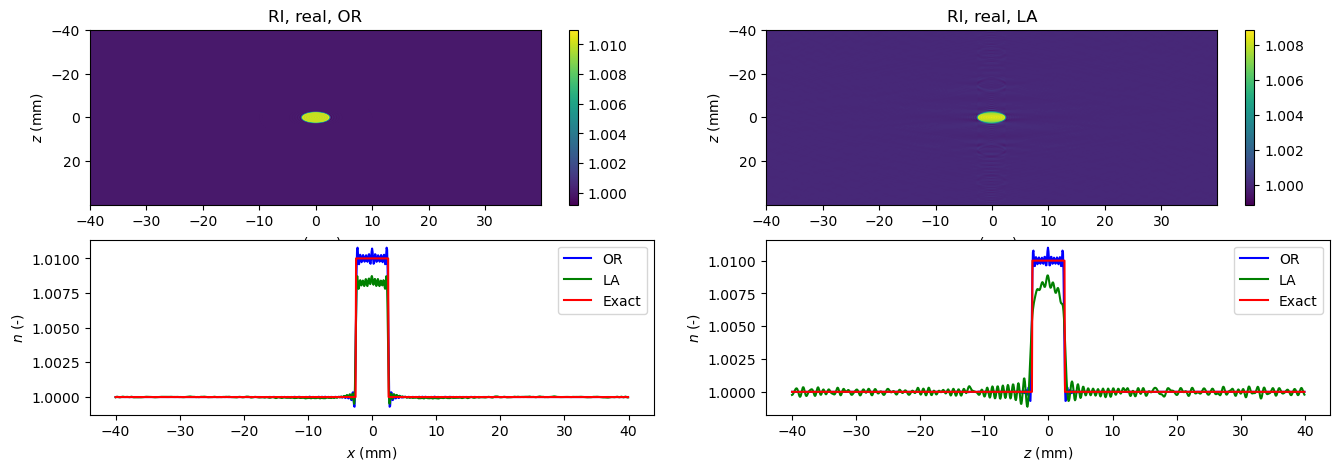

In [126]:
plt.figure(figsize=[16,5])
plt.subplot(221)
plt.title("RI, real, OR")
plt.imshow(np.real(RI_OR), extent = [x_array.min(), x_array.max(), x_array.max(), x_array.min()], aspect = 'auto')
plt.colorbar()
plt.xlabel("$x$ (mm)")
plt.ylabel("$z$ (mm)")
plt.subplot(222)
plt.title("RI, real, LA")
plt.imshow(np.real(RI_LA), extent = [x_array.min(), x_array.max(), x_array.max(), x_array.min()], aspect = 'auto')
plt.colorbar()
plt.xlabel("$x$ (mm)")
plt.ylabel("$z$ (mm)")
plt.subplot(223)
x_plot = np.linspace(-Mie_scattering.x0, Mie_scattering.x0 - Mie_scattering.deltax, int(len(RI_LA[int(len(RI_LA)/2)])))
plt.plot(x_array, np.real(RI_OR[int(len(RI_OR)/2),:]), '-b', label = 'OR')
plt.plot(x_plot, np.real(RI_LA[int(len(RI_LA)/2),:]), '-g', label = 'LA')
plt.plot(x_array, np.real(RI_true[int(len(RI_true)/2), :]), 'r-', label ='Exact')
plt.legend()
plt.xlabel("$x$ (mm)")
plt.ylabel("$n$ (-)")
plt.subplot(224)
plt.plot(x_array, np.real(RI_OR[:, int(len(RI_OR)/2)]), '-b', label = 'OR')
plt.plot(x_array, np.real(RI_LA[:, int(len(RI_LA[0,:])/2)]), '-g', label = 'LA')
plt.plot(x_array, np.real(RI_true[:, int(len(RI_true)/2)]), 'r-', label ='Exact')
plt.legend()
plt.xlabel("$z$ (mm)")
plt.ylabel("$n$ (-)")
plt.show()

## SSNP
The second method is the Split-Step Non-Paraxial (SSNP) method which is based on Zhu \cite{Zhu:22}. This method is originally designed for Intensity Diffraction Tomography (IDT) and for three-dimensional (3D) computations, but since this method computes the field at a certain distance $z_n$ it is also applicable for computing the complex field. This method solves the internal field slice-by-slice. The detailed derivation is in Zhu \cite{Zhu:22}. Note that now the 2D method is derived.
This method again uses the inhomogeneous Helmholtz equation, but here it is rewritten in the Matrix notation as follows
\begin{equation}
    \frac{\partial \boldsymbol{\Phi}}{\partial z} = \mathbf{H}(\mathbf{r}) \boldsymbol{\Phi} (\mathbf{r} ),
\end{equation}
where
\begin{equation}
    \boldsymbol{\Phi} (\mathbf{r}) = \begin{pmatrix} U (\mathbf{r})\\  \frac{\partial U(\mathbf{r})}{\partial z} \end{pmatrix},
\end{equation}
and 
\begin{equation}
    \mathbf{H} (\mathbf{r}) = \begin{pmatrix} 0 & 1\\  -\frac{\partial^2 }{\partial x^2} - k_m^2 ( n_m^2 - n^2 (\mathbf{r}) )& 0 \end{pmatrix}.
\end{equation}
The vector $\boldsymbol{\Phi}$ contains both the field and the $z$-derivative of the field. By splitting matrix $H(\mathbf{r})$ into a scattering operator and a diffraction operator we get $\mathbf{H} (\mathbf{r}) = \mathbf{H}_1  + \mathbf{H}_2 (\mathbf{r})$ with
\begin{equation}
    \mathbf{H}_1 = \begin{pmatrix} 0 & 1\\  \frac{\partial^2 }{\partial x^2} - k_m^2 n_m^2 & 0 \end{pmatrix},
\end{equation}
and 
\begin{equation}
    \mathbf{H}_2  (\mathbf{r})= \begin{pmatrix} 0 & 0\\  k_m^2 (n_m^2 - n^2 (\mathbf{r}) ) & 0 \end{pmatrix}.
\end{equation}
By introducing these matrices one becomes spatial invariant ($\mathbf{H}_1$) describing the propagation in a homogeneous background medium. This system can be solved by approximating the equation as a first-order homogeneous linear system of differential equations. This solution then becomes
\begin{equation}
    \boldsymbol{\Phi} (z + \Delta z) = \text{e}^{\mathbf{H} (r) \Delta z} \boldsymbol{\Phi} \approx \mathbf{P Q} (z) \boldsymbol{\Phi} (z),
\end{equation}
with $\boldsymbol{\Phi} (z)$ the field and its $z$-derivative at slice $z$ and
\begin{equation}
    \mathbf{P} = \text{e}^{\mathbf{H}_1 \Delta z},
\end{equation}
and 
\begin{equation}
    \mathbf{Q} (z) = \text{e}^{\mathbf{H}_2 (x,z) \Delta z}.
\end{equation}
The propagation in the homogeneous background medium can be computed via $\mathbf{P}$ which can be solved using the Fourier transform
<!-- \begin{equation}
\begin{matrix}    \mathbf{P} \boldsymbol{\Phi} =&  \mathcal{F}^{-1}_x\left \{\mathbf{\tilde{P}} \mathcal{F}_x \{ \boldsymbol{\Phi}\} \right \} \\ \mathbf{P} \boldsymbol{\Phi}  =& \mathcal{F}^{-1}_x\left \{\begin{pmatrix} \cos{k_z \Delta z} & \frac{\sin{k_z \Delta z}}{k_z} \\     - k_z \sin{k_z \Delta z}&\cos{k_z \Delta z} \end{pmatrix} \mathcal{F}_x \{ \boldsymbol{\Phi}\} \right \} \end{matrix}
\end{equation} -->
$$
\begin{equation}
\begin{aligned}
\mathbf{P} \boldsymbol{\Phi} &= \mathcal{F}^{-1}_x\left\{\mathbf{\tilde{P}} \mathcal{F}_x \{\boldsymbol{\Phi}\}\right\} \\
\mathbf{P} \boldsymbol{\Phi} &= \mathcal{F}^{-1}_x\left\{
\begin{pmatrix}
\cos(k_z \Delta z) & \frac{\sin(k_z \Delta z)}{k_z} \\
- k_z \sin(k_z \Delta z) & \cos(k_z \Delta z)
\end{pmatrix}
\mathcal{F}_x \{\boldsymbol{\Phi}\}\right\}
\end{aligned}
\end{equation}
$$
where $\mathcal{F}_x$ and $\mathcal{F}_x^{-1}$ represent the $1D$ Fourier and inverse Fourier transform on the $x$-line and $k_x$ is the corresponding $\mathbf{k}$-component which gives us $k_z = \sqrt{k_m^2 n_m^2 - k_x^2}$ if $k_x^2 \leq k_m^2 n_m^2$, otherwise $\mathbf{\tilde{P}} = \mathbf{0}$ in order to remove the evanescent component. 
The operator $\mathbf{Q} (z)$ computes the scattered field induced by the difference in the refractive index at a slice $z$ and can be computed directly in real space by 
\begin{equation}
    \mathbf{Q} (z) \boldsymbol{\Phi} = \begin{pmatrix}1 & 0 \\ k_m^2 (n_m^2 - n_x^2 (z)) \Delta z & 1\end{pmatrix} \boldsymbol{\Phi}.
\end{equation}
In order to find the solution of the wavefield a the position $z_n$, operators $\mathbf{P}$ and $\mathbf{Q}$ are recursively calculated slice-by-slice.
As an initial condition for this algorithm a plane wave is used which is at slice $0$. The plane wave is defined as 
\begin{equation}
    \boldsymbol{\Phi}_0 = \text{e}^{j k_x^{in} x} \begin{pmatrix}1 \\j k_z^{in}\end{pmatrix}
\end{equation}
with $k_x^{in} = 0$ and $k_z^{in} = k_m$ for an incoming wave in the $z$-direction. The field at position $z_n$ consists both the forward and backward field. The backward field induces high-frequency artifacts \cite{Lim2019}, so we are only interested in the forward field. This field is obtained by
\begin{equation}
        U_{\text{for}} = \mathbf{F} \boldsymbol{\Phi} = \mathcal{F}_x^{-1} \left \{ \left ( \frac{1}{2}, \; \frac{-j}{2k_z} \right ) \mathcal{F}_x \{\boldsymbol{\Phi}\} \right \}.
\end{equation}
The total field will then be 
\begin{equation}
    U_{\text{for}} = \mathbf{F} \mathbf{P} \mathbf{Q}(z_{n-1}) \cdots \mathbf{P} \mathbf{Q} (z_1) \mathbf{P} \mathbf{Q} (z_0) \boldsymbol{\Phi}_0 .
\end{equation}

In [106]:
def SSNP_wave(nx, param):
    # Define kx
    kx = 2.0*np.pi*np.fft.fftfreq(param.Nx, param.deltax)

    # Define filter kx^2 < km^2
    filter_klp = kx**2 < param.km**2

    # Define filter as a tensor
    filter_klp_tensor = tf.ones(filter_klp.size, dtype = tf.complex64) * filter_klp

    # Define kz
    kz = tf.sqrt(filter_klp*(param.km**2 - kx**2))

    # Cast to a tensor
    kz_tensor = tf.cast(kz, dtype = tf.complex64)

    # Where equal to zero replace value with 1e10 (because this is only used for 1/kz and it should be zero which gives an error in tensorflow)
    # a division with a high number gives approx zero
    kz_tensor = tf.where(tf.equal(kz_tensor, 0), tf.zeros_like(kz_tensor)+1e10, kz_tensor)

    # Define matrix Q (elementwise) (Q10 gets computed every z-step)
    Q00 = 1
    Q01 = 0
    Q11 = 1

    # Define matrix P
    P00 = tf.cast(tf.cos(kz*param.deltaz) *filter_klp, dtype  = tf.complex64)
    P11 = P00
    P01 = tf.cast(tf.where(tf.equal(kz, 0), tf.zeros_like(kz), tf.sin(kz * param.deltaz) / kz ), dtype = tf.complex64)
    P10 = tf.cast(-1*kz*tf.sin(kz*param.deltaz) * filter_klp, dtype  = tf.complex64)

    # Define x_array 
    x_array = np.linspace(-param.x0, param.x0-param.deltax, param.Nx)

    # First compute the initial conditions for u and du/dz (==du)
    u = tf.exp(complex_j*param.kx_in*x_array)
    du = complex_j*param.kz_in*u

    # Loop over all the z-values to compute the field in every slice
    for i in range(param.Nz - 1):
        # Update Q10
        Q10 = tf.complex((param.km**2 - param.k0**2 * (nx[i,:])**2) * param.deltaz, tf.constant(0.0, dtype = tf.float32))

        # Apply matrix Q on u en du and update both (use temp such that u is not update for the update of du)
        temp = u*Q00 + du*Q01
        du = u*Q10 + du*Q11
        u = temp

        # # FFT of u and du in order to apply matrix P
        a = tf.signal.fft(u)
        da = tf.signal.fft(du)

        # Apply matrix P
        temp = a*P00 + da*P01
        da = a*P10 + da*P11
        a = temp 
     
        # IFFT to find u and du
        u = tf.signal.ifft(a)
        du = tf.signal.ifft(da)

    # After the loop compute the Forward Field such that High-frequencies disappear

    # First perform fft
    a = tf.signal.fft(u)
    da = tf.signal.fft(du)

    # Compute the fourier transform of phi_out
    temp = (1/2*a *filter_klp_tensor + -1j/(2*kz_tensor) * da) 

    # Inverse fourier transform to compute phi_out
    phi_out = tf.signal.ifft(temp)

    # return phi_out which is a tensor of Nz x Nx
    return phi_out

In [ ]:
# Define new cylinder scattering class
SSNP_class = Cylinder_Scattering(Nx = 1024, Nz = 1024)

# Define x- and z-array
x_array = np.linspace(-SSNP_class.x0, SSNP_class.x0-SSNP_class.deltax, SSNP_class.Nx)
z_array = np.linspace(-SSNP_class.z0, SSNP_class.z0-SSNP_class.deltaz, SSNP_class.Nz)

# Define the RI nx (now for a cylinder with radius R0)
object = (x_array[:,None]**2 + (z_array[None,:])**2) < SSNP_class.R0**2
nx = SSNP_class.nmed + (SSNP_class.ncyl - SSNP_class.nmed)*object
nx_parse = nx

# Make nx a tensor
nx = tf.convert_to_tensor(nx, dtype=tf.float32)

# run function
phi_out = SSNP_wave(nx, SSNP_class)

# Also run with nx = nmed, for non-scattering
phi_out_ns = SSNP_wave(SSNP_class.nmed * tf.ones((SSNP_class.Nz, SSNP_class.Nx)), SSNP_class)

# Compute U_exact
Uexact, UB, UR = Compute_Wave_Mie(SSNP_class)

# plot scattered field
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(x_array, np.abs(Uexact), label = 'exact')
plt.plot(x_array, np.abs(phi_out.numpy() - phi_out_ns.numpy()), label = 'SSNP')
plt.xlabel("$x$ (mm)")
plt.ylabel("$||U||$ (-)")
plt.legend()
plt.subplot(122)
plt.plot(x_array, np.angle(Uexact), label = 'exact')
plt.plot(x_array, np.angle(phi_out.numpy() - phi_out_ns.numpy()), label = 'SSNP')
plt.xlabel("$x$ (mm)")
plt.ylabel("$angle(U)$ (-)")
plt.legend()
plt.show()

In order to reconstruct the refractive index from the measured data with the SSNP model, an optimization problem is introduced as
\begin{equation}
    \hat{n} = \text{argmin}_n \left \{ \left | \left | U_{s}^{\text{for}} - U_{s}^{\text{meas}} \right | \right |^2_2 + \left | \left | \sqrt{I_s^{for}} - \sqrt{I_s^{meas}} \right | \right |^2_2 + \tau R_{\text{TV}} (n) \right \},
\end{equation}
with $\hat{n}$ the refractive index for which the function inside the argmin is minimal, and $I_s^{for}$ and $I_s^{meas}$ the obtained intensity from the scattered field of both the SSNP forward model and the measured data. Two $L_2$-norms are taken such that both the phase difference and intensity difference are taken into account. The last term is a regularization term which is included to prevent overfitting. In this thesis the $L_1$-norm of the refractive index is chosen, however there are other possibilities such as the derivative of the the refractive index as the input for the $L_1$-norm. Because this will enlarge the computational complexity of an already highly complex problem, due to the addition of the computation of a second order derivative, this regularization is not taken. $\tau$ is the regularization parameter which is set equal to $0.2$ in line with Zhu.

For the reconstruction we use the tensorflow package which could run on CPU and GPU (GPU often faster). The next script check where it runs now. 

In [ ]:
# Get the list of visible devices
visible_devices = tf.config.experimental.list_physical_devices()

# Check if any GPU is available
gpu_available = any(device.device_type == 'GPU' for device in visible_devices)

# Print the result
if gpu_available:
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is using CPU.")


Now we define a loss function which defines the cost of the function.

In [ ]:
def compute_loss(phi, phi_meas):
    return tf.norm(tf.math.abs(phi-phi_meas), ord=2) + tf.norm(tf.math.abs(phi)-tf.math.abs(phi_meas), ord = 2)

Next define a function which can be called to perform the reconstruction.

In [ ]:
# Input parameters are estimated_nx_real which is the estimated value of the RI, phi_meas (the measured exact field)
# and phi_out_ns which is the field without scattering computed with SSNP_wave
def reconstruction_tensorflow(estimated_nx, phi_meas, phi_out_ns, param):
    estimated_nx_real = estimated_nx
    # Define optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=param.learn_rate)

    i = 0
    # Compute loss
    loss_1 = np.empty(param.indmax+1)

    # Define two random values
    loss_1[0] = param.Nx*param.Nz
    loss = param.Nx*param.Nz - 1
    while loss < loss_1[i]:
        i += 1
        loss_1[i] = loss

        if i >= param.indmax:
            break
        with tf.GradientTape() as tape:
            # Define the loss
            l2_norm = compute_loss(phi=SSNP_wave(estimated_nx_real, param) - phi_out_ns, phi_meas=phi_meas) / param.Nx  # evaluate the loss
            l1_norm = tf.math.reduce_sum(tf.math.abs(estimated_nx_real)) / (param.Nx*param.Nz)

            loss = l2_norm+param.gamma*l1_norm

        # Check if loss decreases
        if loss_1[i] < loss:
            print("The cost functions increases. Stop.")
            break

        print('iteration ' + str(i) + ': loss = ' + str(loss.numpy()))

        # Apply gradient
        [dphi_dnx_real] = tape.gradient(loss, [estimated_nx_real])
        optimizer.apply_gradients(zip([dphi_dnx_real], [estimated_nx_real]))
    
    return estimated_nx_real
        


In [ ]:
parameters = Cylinder_Scattering(learn_rate=25, gamma = 0.2, angle_deg=16, Nx = 1024*2, Nz = 1024*2, indmax=20)

# Define initial value of nx
estimated_nx_1 = tf.Variable(tf.ones([parameters.Nz,parameters.Nx],dtype = tf.float32))

# Define value of the scattered field if n(r) = 1.0 (non-scattering)
phi_out_ns = SSNP_wave(estimated_nx_1, parameters)
phi_out_ns = tf.constant(phi_out_ns, dtype = tf.complex64)

# Define exact wave
phi_meas = tf.convert_to_tensor(Compute_Wave_Mie(parameters), dtype = tf.complex64) 
phi_meas = tf.constant(phi_meas, dtype = tf.complex64) 

for j in range(parameters.angle_deg):
    print("New angle, start with angle {:.1f} degrees".format(parameters.angle_step*j))
    estimated_nx_1 = tf.Variable(scipy.ndimage.rotate(estimated_nx_1.numpy(), parameters.angle_step, reshape = False, cval = parameters.nmed), dtype = tf.float32)
    plt.imshow(estimated_nx_1.numpy(), aspect='auto')
    plt.colorbar()
    plt.show()

    estimated_nx_1 = reconstruction_tensorflow(estimated_nx_1, phi_meas, phi_out_ns, parameters)


    

Or it could be run with the OR as input

In [ ]:
parameters = Cylinder_Scattering(learn_rate=25, gamma = 0.2, angle_deg=16, Nx = 1024*2, Nz = 1024*2, indmax=20)

# Define initial value of nx
# Define guess for our function
Uexact, UB, UR = Compute_Wave_Mie(parameters)

U1 = np.expand_dims(Uexact, axis=1)                   
# repeat the data in the column direction
sinogram_Exact=np.repeat(U1, parameters.Nphi, axis=1)
RI_guess = Fourier_Backprojection_Theorem_OR(sinogram_Exact)

# Convert to tensor
estimated_nx_1 = tf.Variable(tf.convert_to_tensor(np.real(RI_guess), dtype = tf.float32))

# Define value of the scattered field if n(r) = 1.0 (non-scattering)
phi_out_ns = SSNP_wave(tf.ones([parameters.Nz, parameters.Nx], dtype = tf.float32), parameters)
phi_out_ns = tf.constant(phi_out_ns, dtype = tf.complex64)

# Define exact wave
phi_meas = tf.convert_to_tensor(Compute_Wave_Mie(parameters), dtype = tf.complex64) 
phi_meas = tf.constant(phi_meas, dtype = tf.complex64) 

for j in range(parameters.angle_deg):
    print("New angle, start with angle {:.1f} degrees".format(parameters.angle_step*j))
    estimated_nx_1 = tf.Variable(scipy.ndimage.rotate(estimated_nx_1.numpy(), parameters.angle_step, reshape = False, cval = parameters.nmed), dtype = tf.float32)
    plt.imshow(estimated_nx_1.numpy(), aspect='auto')
    plt.colorbar()
    plt.show()

    estimated_nx_1 = reconstruction_tensorflow(estimated_nx_1, phi_meas, phi_out_ns, parameters)


    